## Predicting Precipitation Phase (Classifier)

#### *By: Heaton Chan, Rana Ghadymimahani, Renée Choquette, and Amitaditya Paul*

### Introduction:

Weather is one of the few aspects in human existence that has a great impact on our daily lives, but we have little control over it. Weather is also becoming increasingly difficult to predict due to climate change and global warming. Due to global warming, a direct consequence is the shift in precipitation phase from snow to rain (https://onlinelibrary.wiley.com/doi/full/10.1111/1752-1688.12443). We believe that computer analysis is one of the most promising methods to achieve accurate weather predictions. Using data analysis, we wanted to explore the trends and impacts that in weather patterns, to better predict the precipitation phase in a given region. In our project, we will be exploring a weather dataset to answer the following question: “Given the dew point and daily high and low temperatures in a weather data set of a region in the United States, what type of precipitation (if any) will occur?”. The original dataset contains weather data from different countries in the year of 2020. We chose to focus only on data from the United States because it has the greatest amount of data, and we will therefore get the most accurate outcome (as explained in the Exploring Data section). We used the following variables: dew point, daily high temperature, and daily low temperature as our predictors (as explained in the Choosing and Visualizing Predictors section), because through trial and error based on research we found those predictors to give the most accurate and clear outcome. 

### Methods:

First, we loaded the packages needed to perform our analysis.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
library(gridExtra)
library(rvest)
library(stringr)
library(infer)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Read Data:
Then we loaded and read our data from a remote source.

In [3]:
url = "https://raw.githubusercontent.com/codingonapotato/dsci100_group_project_S2022/main/data/daily_weather_2020.csv"
download_weather <- download.file(url, destfile = "daily_weather_2020.csv")  # Object used to summon the file from the internet to the local machine

weather_data_raw <- suppressWarnings(read_csv("daily_weather_2020.csv")) %>%
                        select(-X1) %>% #Gets rid of the column keeping track of column numbers
                        rename("Country" = "Country/Region")
glimpse(weather_data_raw)

Parsed with column specification:
cols(
  .default = col_double(),
  `Country/Region` = col_character(),
  `Province/State` = col_character(),
  time = col_date(format = ""),
  summary = col_character(),
  icon = col_character(),
  precipType = col_character()
)

See spec(...) for full column specifications.



Rows: 30,688
Columns: 44
$ Country                     <chr> "Afghanistan", "Afghanistan", "Afghanista…
$ `Province/State`            <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ time                        <date> 2019-12-31, 2020-01-01, 2020-01-02, 2020…
$ summary                     <chr> "Rain (with a chance of 1–3 in. of snow) …
$ icon                        <chr> "rain", "rain", "rain", "partly-cloudy-da…
$ sunriseTime                 <dbl> 1577846640, 1577933040, 1578019440, 15781…
$ sunsetTime                  <dbl> 1577882700, 1577969160, 1578055560, 15781…
$ moonPhase                   <dbl> 0.20, 0.23, 0.26, 0.30, 0.33, 0.36, 0.39,…
$ precipIntensity             <dbl> 0.0156, 0.0235, 0.0016, 0.0003, 0.0145, 0…
$ precipIntensityMax          <dbl> 0.1515, 0.0985, 0.0062, 0.0012, 0.0310, 0…
$ precipIntensityMaxTime      <dbl> 1577902320, 1577907000, 1578009780, 15781…
$ precipProbability           <dbl> 0.71, 0.95, 0.25, 0.14, 0.83, 0.91, 0.12,…
$ precipType               

`Table 1:` Raw Weather Data Table

#### Exploring Data

We first explored our data by finding all of the columns in the dataframe and then determine how many rows belong to each country. From `count` we discovered that the US had the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier, thus we decided to filter our data to only contain data from the US.

In [4]:
names <- colnames(weather_data_raw) # So that we can see all the column names in the dataframe

count <- weather_data_raw %>%
            group_by(Country) %>%
            summarize(number_of_rows = n()) %>%
            arrange(desc(number_of_rows)) 
            #glimpse()    # !!! <Ask Nour if glimpse or non glimpse ver. matters for readability>    
            # So that we can see the rows of data we have to work with in each region  

weather_data_US_only <- weather_data_raw %>%
            select(Country, precipProbability, temperatureHigh, temperatureLow, dewPoint, windSpeed, windGust, precipType) %>%
            filter(Country == "US") # dataframe that only contains data from US  
glimpse(weather_data_US_only)

`summarise()` ungrouping output (override with `.groups` argument)



Rows: 6,272
Columns: 8
$ Country           <chr> "US", "US", "US", "US", "US", "US", "US", "US", "US…
$ precipProbability <dbl> 0.04, 0.07, 0.96, 0.98, 0.37, 0.06, 0.06, 0.12, 0.0…
$ temperatureHigh   <dbl> 60.37, 61.00, 68.09, 63.40, 59.38, 60.45, 67.34, 62…
$ temperatureLow    <dbl> 32.53, 47.42, 61.20, 54.90, 30.98, 35.99, 50.55, 31…
$ dewPoint          <dbl> 32.58, 30.54, 54.40, 61.56, 43.43, 30.59, 42.38, 37…
$ windSpeed         <dbl> 5.86, 2.30, 7.90, 5.23, 9.91, 2.78, 3.60, 8.67, 2.6…
$ windGust          <dbl> 20.02, 7.52, 34.34, 32.49, 30.70, 10.96, 17.94, 25.…
$ precipType        <chr> "rain", "rain", "rain", "rain", "rain", "rain", "ra…


`Table 2:` Weather Data Table with Observations from the US

#### Dropping `NA`'s and Final Tidy Data

We then wanted to explore how many of the rows in our data are blank (listed as `NA`) and filter these rows out to produce our final tidy dataset (`weather_data`). We also included a table which summarizes the number of rows with all US data (including those with `NA`'s), how many of those rows contained missing values, and how many rows remain in the final tidy dataset. In addition, we wanted to see whether or not our data is balanced in terms of the proportion of rain vs. snow precipTypes. We saw that the ratio of rain to snow datapoints were about 70:30, thus we knew that we would need to balance our training data prior to building our classification model.

In [5]:
na_count <- weather_data_US_only %>%
                filter(is.na(precipProbability) 
                       | is.na(temperatureHigh) 
                       | is.na(temperatureLow) 
                       | is.na(dewPoint)
                       | is.na(windGust)
                       | is.na(windSpeed)
                       | is.na(precipType)) %>%
                nrow() # To show the amount of missing data in our variables

weather_data <- weather_data_US_only %>% 
    drop_na() %>%
    mutate(precipType = as.factor(precipType)) %>%
    glimpse()#dropping all NA values from the dataset and mutating precipType into a factor

Rows: 6,246
Columns: 8
$ Country           <chr> "US", "US", "US", "US", "US", "US", "US", "US", "US…
$ precipProbability <dbl> 0.04, 0.07, 0.96, 0.98, 0.37, 0.06, 0.06, 0.12, 0.0…
$ temperatureHigh   <dbl> 60.37, 61.00, 68.09, 63.40, 59.38, 60.45, 67.34, 62…
$ temperatureLow    <dbl> 32.53, 47.42, 61.20, 54.90, 30.98, 35.99, 50.55, 31…
$ dewPoint          <dbl> 32.58, 30.54, 54.40, 61.56, 43.43, 30.59, 42.38, 37…
$ windSpeed         <dbl> 5.86, 2.30, 7.90, 5.23, 9.91, 2.78, 3.60, 8.67, 2.6…
$ windGust          <dbl> 20.02, 7.52, 34.34, 32.49, 30.70, 10.96, 17.94, 25.…
$ precipType        <fct> rain, rain, rain, rain, rain, rain, rain, rain, rai…


`Table 3:` Final Tidy Weather Dataset with Missing Values Removed

In [6]:
unified_tibble <- slice(count, 1) %>%
                    mutate(number_of_missing_values = na_count) %>%
                    mutate(number_of_rows_final = nrow(weather_data))
unified_tibble #Aggregate table for column number and number of *previously missing values in the dataset that got removed

Country,number_of_rows,number_of_missing_values,number_of_rows_final
<chr>,<int>,<int>,<int>
US,6272,26,6246


`Table 4:` Summary Table Showing the Number of Rows, Missing Values, and Final Number of Rows after Removing Rows with Missing Values

In [7]:
class_count <- weather_data %>%
                select(precipType) %>%
                count(precipType) %>%
                mutate(proportion = n/nrow(weather_data))
class_count # Formally show the amount of each label we have in our tidy dataset

precipType,n,proportion
<fct>,<int>,<dbl>
rain,4344,0.6954851
snow,1902,0.3045149


`Table 5:` Summary Table Showing the Number of Observations for each precipType and their Relative Proportion in the Total Tidy Dataset

#### Splitting Data & Upsampling

We then split our original dataset into a training set (70% of original data) and a testing set (other 30% of original data). In addition, we upsampled our training data to produce a balanced dataset (`weather_train_upsampled`) for training our model.

In [8]:
set.seed(2022)

weather_split <- weather_data %>%
                initial_split(prop = 0.7, strata = precipType)

weather_training <- training(weather_split) #training dataset

weather_testing <- testing(weather_split) #testing dataset

weather_upsampling_recipe <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh + precipProbability, data = weather_training) %>%
    step_upsample(precipType, over_ratio = 1, skip = FALSE) 

weather_train_upsampled <- weather_upsampling_recipe %>% 
                            prep() %>% 
                            bake(weather_training)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [9]:
data_proportions <-  tibble(proportion_of_total_in_training = (nrow(weather_training)/nrow(weather_data))) %>%
                        mutate(proportion_of_total_in_testing = (nrow(weather_testing)/nrow(weather_data)))
data_proportions # To formally show the percentage of the tidy dataset that went into the training and testing datasets

proportion_of_total_in_training,proportion_of_total_in_testing
<dbl>,<dbl>
0.7001281,0.2998719


`Table 6:` Summary Table Showing the Relative Proportions of the Tidy Weather Dataset in the Training and Testing Datasets 

In [10]:
class_count_upsampled <- weather_train_upsampled %>%
                            select(precipType) %>%
                            count(precipType) %>%
                            mutate(proportion = n/nrow(weather_train_upsampled))
class_count_upsampled # Formally shows whether labels got upsampled successfully (looks like a yes to me!)

precipType,n,proportion
<fct>,<int>,<dbl>
rain,3041,0.5
snow,3041,0.5


`Table 7:` Summary Table Showing the Proportion of Each precipType Label in the Training Dataset after Upsampling

#### Choosing and Visualizing Predictors

The weather data set has many options for predictors, so to choose the ones that would provide the most accuracy, we conducted some research. Initially, we looked at a research paper from Hydrology Research by James Feiccabrino, Angela Lundberg, and David Gustafsson. This paper explores different strategies for determining precipitation phase, and which strategies are most accurate. They found that precipitation phase “separation can be done using easily identifiable surface air mass boundary characteristics such as surface air temperature, wind speed and wind direction” (https://iwaponline.com/hr/article/43/3/179/31249/Improving-surface-based-precipitation-phase). Using this information, we tried using `temperatureHigh`, `temperatureLow`, `windGust`, and `windSpeed` as our predicting variables and visualizing them.

In [11]:
weather_train_means <- weather_train_upsampled %>%
                            select(-precipType) %>%
                            map_df(mean) %>%
                            rename(mean_dewPoint = dewPoint,
                                  mean_precipProbability = precipProbability,
                                  mean_windGust = temperatureHigh,
                                  mean_windSpeed = temperatureLow) #computed means for across all columns

weather_train_total <- tibble(total_rows_in_training = nrow(weather_train_upsampled)) #total number of rows for training data

weather_train_aggregate <- weather_train_total %>%
                                bind_cols(weather_train_means) #aggregated summary tables for the training data 
weather_train_aggregate

# possibly use the means as a MEANS (haha) to justify scaling the data? (i mean other than the fact that its standard practice for k-nn)

total_rows_in_training,mean_dewPoint,mean_windSpeed,mean_windGust,mean_precipProbability
<int>,<dbl>,<dbl>,<dbl>,<dbl>
6082,28.85053,32.28422,48.23936,0.3026077


`Table 8: ` Summary Table Showing the Means of the Predictor Variables in the Upsampled Training Dataset

TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]

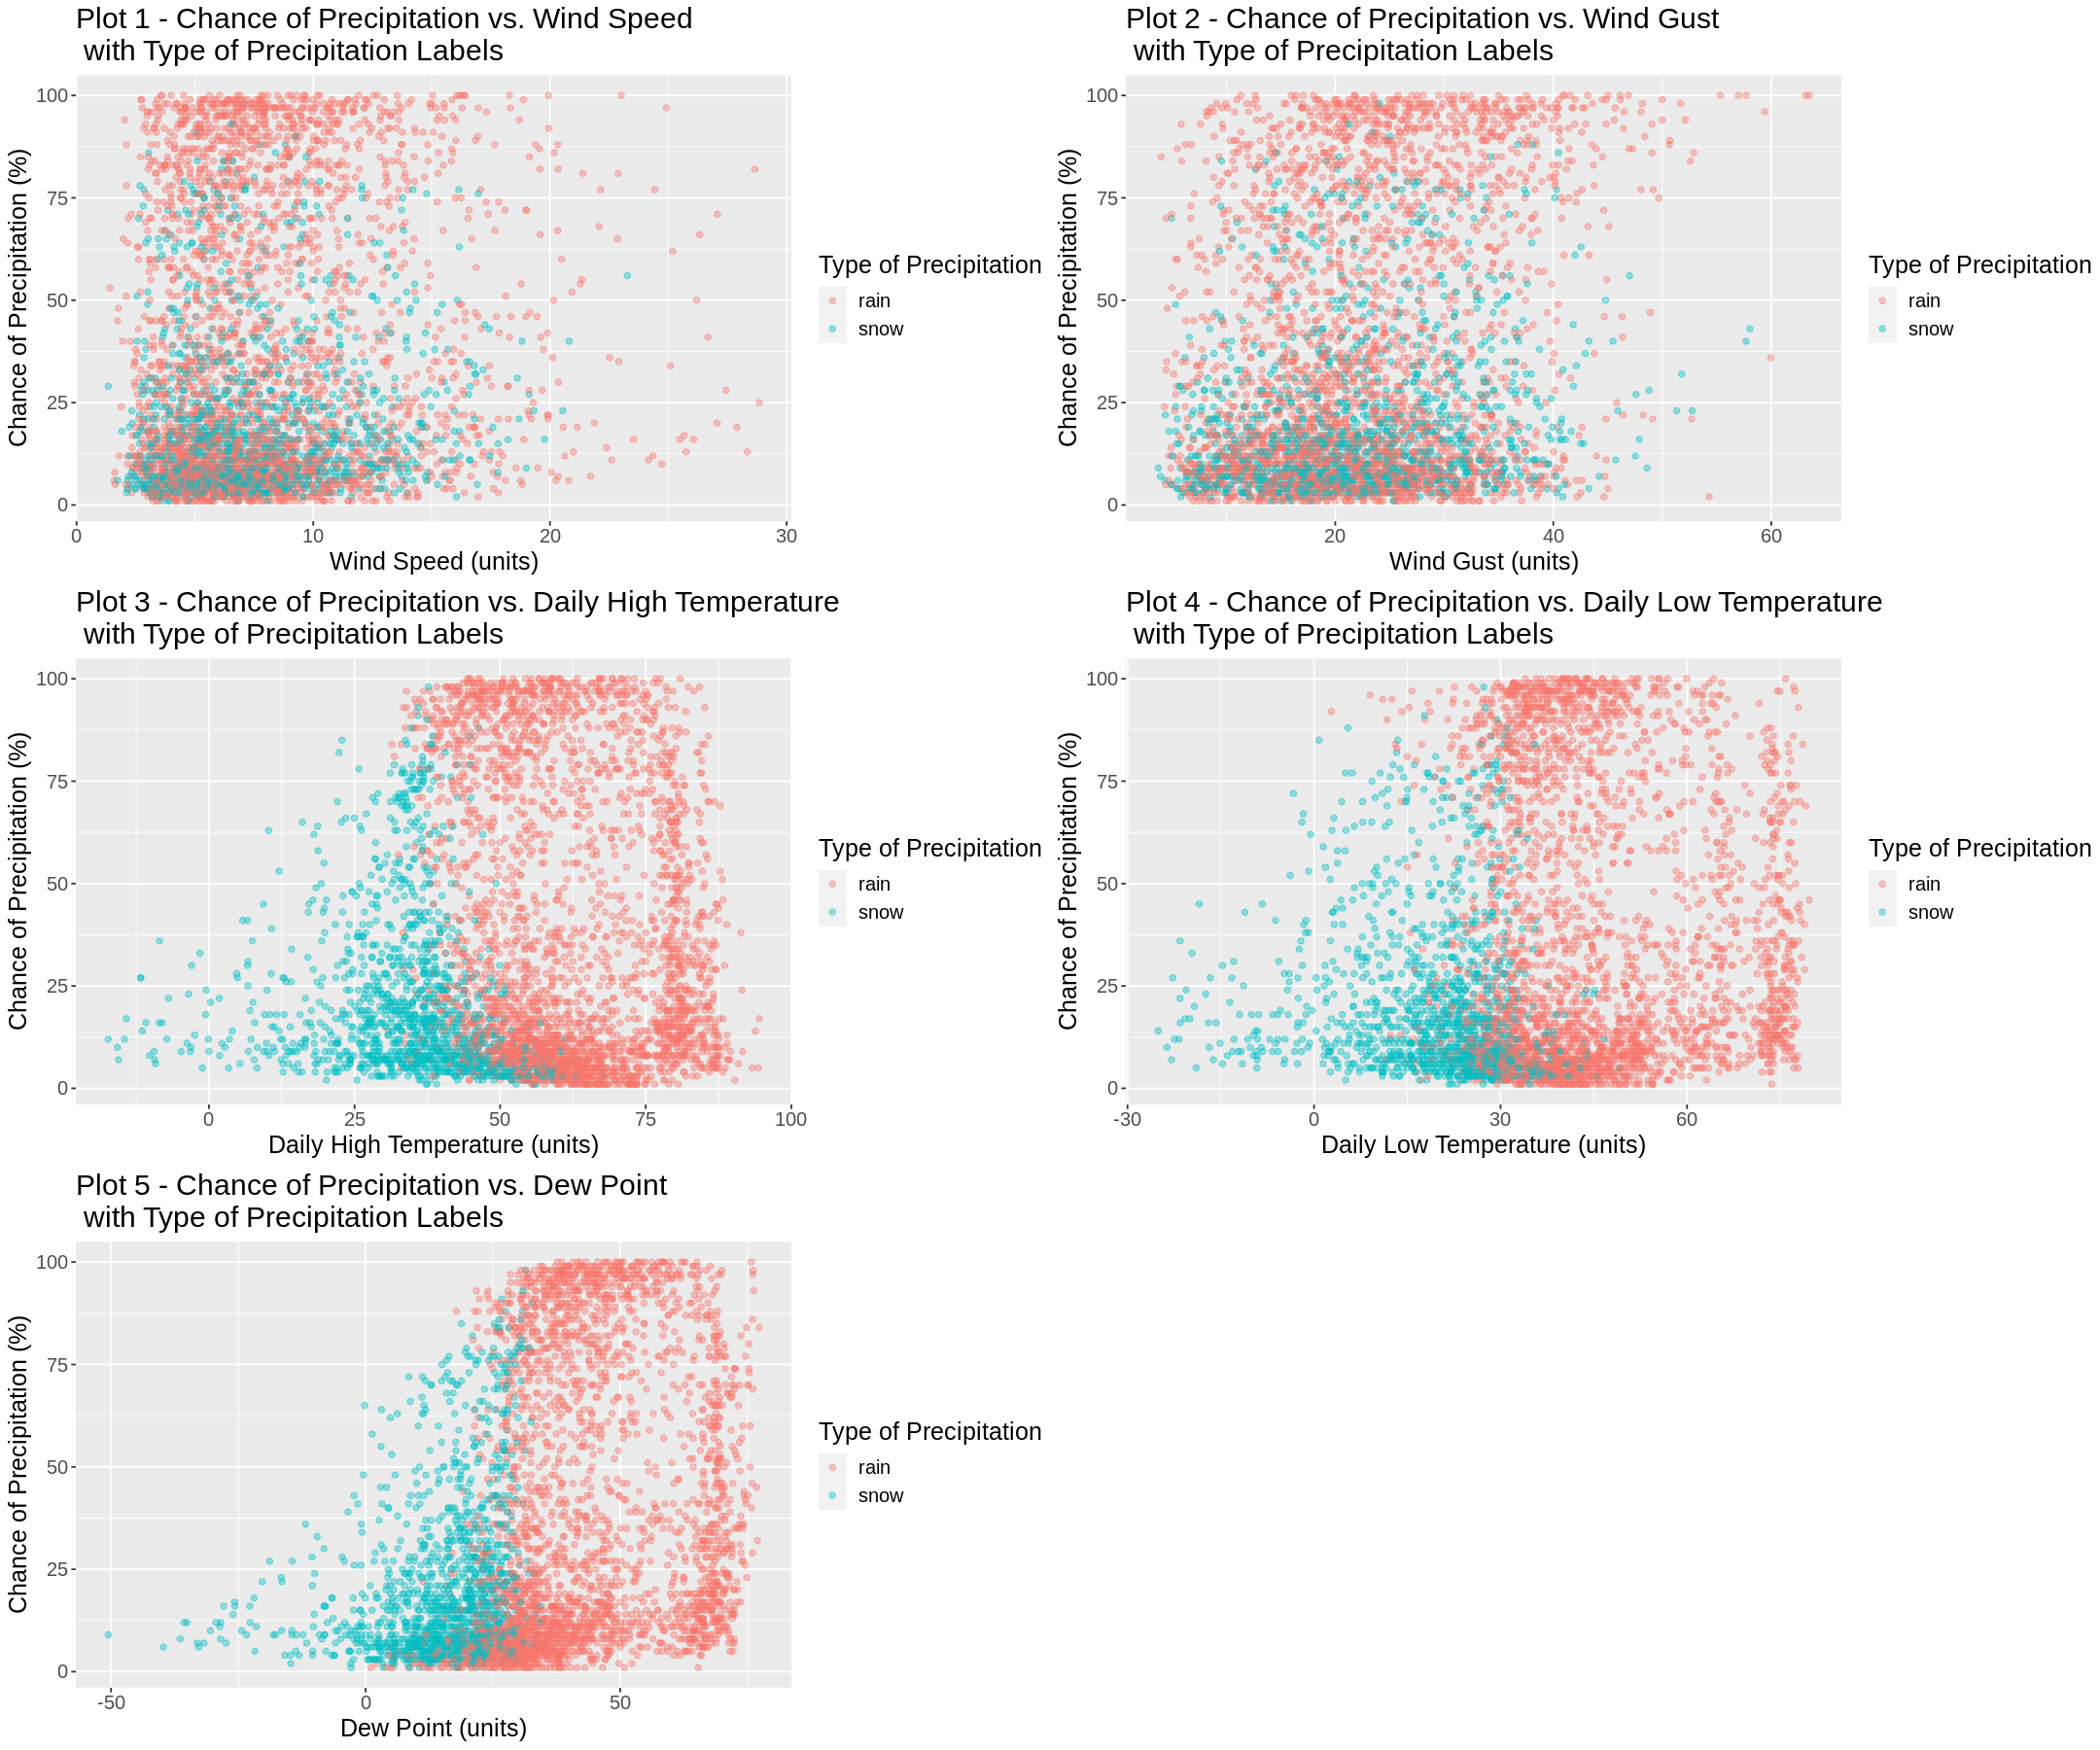

In [12]:
options(repr.plot.width = 18, repr.plot.height = 15)
plot1 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = windSpeed, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Wind Speed (miles per hour)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 1 - Chance of Precipitation vs. Wind Speed \n with Type of Precipitation Labels")

plot2 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = windGust, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Wind Gust (miles per hour)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 2 - Chance of Precipitation vs. Wind Gust \n with Type of Precipitation Labels")

plot3 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureHigh, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily High Temperature (degrees Fahrenheit)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 3 - Chance of Precipitation vs. Daily High Temperature \n with Type of Precipitation Labels")
plot4 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureLow, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily Low Temperature (degree Fahrenheit)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 4 - Chance of Precipitation vs. Daily Low Temperature \n with Type of Precipitation Labels")
plot5 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = dewPoint, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Dew Point (degrees Fahrenheit)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 5 - Chance of Precipitation vs. Dew Point \n with Type of Precipitation Labels")

plots_together <- grid.arrange(plot1, plot2, plot3, plot4, plot5, ncol = 2)
plots_together

We saw that there was a clear separation between precipitation phases using the temperature variables, but not with the wind predictors. We decided to use the temperature variables as they were accurate predictors, but continued our research to find another predictor that we could use instead of `windSpeed` and `windGust`. We then explored other resources to help choose which predictors would determine precipitation phase, and found that precipitation phase change is “based on thresholds of  air temperature  at 0 °C, dual [air temperature] threshold, −1 to 3 °C, dew point temperature at 0 °C, and wet bulb temperature at 0 °C” (https://www.sciencedirect.com/science/article/pii/S0309170812002941). So we included dew point into our data by calculating the mean dew point, probability of precipitation, daily high temperature, and daily low temperature. In addition, we plotted our 3 predictors vs. probability of precipitation to visualize our data. From these visualizations, which all show a clear split between snow and rain precipitation types, we concluded that `dewPoint`, `temperatureHigh`, and `temperatureLow` have an effect on precipitation type. 

In [79]:
weather_train_means <- weather_train_upsampled %>%
                            select(-precipType) %>%
                            map_df(mean) %>%
                            rename(mean_dewPoint = dewPoint,
                                  mean_precipProbability = precipProbability,
                                  mean_temperatureHigh = temperatureHigh,
                                  mean_temperatureLow = temperatureLow) #computed means for across all columns

weather_train_total <- tibble(total_rows_in_training = nrow(weather_train_upsampled)) #total number of rows for training data

weather_train_aggregate <- weather_train_total %>%
                                bind_cols(weather_train_means) #aggregated summary tables for the training data 
weather_train_aggregate

# possibly use the means as a MEANS (haha) to justify scaling the data? (i mean other than the fact that its standard practice for k-nn)

total_rows_in_training,mean_dewPoint,mean_temperatureLow,mean_temperatureHigh,mean_precipProbability
<int>,<dbl>,<dbl>,<dbl>,<dbl>
6082,28.85053,32.28422,48.23936,0.3026077


#### Taking a Smaller Sample & Finding the Best K-value

Given that our training data contained over 6,000 rows, we were advised to take a small random stratified sample of our training data to then conduct a cross-validation analysis and find the best K-value for our K-NN model. When tuning, we first tested k-values in the range (1:100) (`k_vals`) and then were able to narrow down the range to (50:75) (`k_vals_narrowed`). We finally obtained a best K-value of 60.

In [19]:
#---------------> DONT RUN THIS CELL CAUSE IT TAKES ALMOST A MINUTE TO RUN <--------------------
set.seed(2022)

weather_train_sample <- weather_train_upsampled %>%
    group_by(precipType) %>%
    sample_n(size = 250)

weather_recipe <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh, data = weather_train_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

weather_vfold <- vfold_cv(weather_train_sample, v = 5, strata = precipType) 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
k_vals_narrowed <- tibble(neighbors = seq(from = 50, to = 75, by = 2))

number_of_neighbors_stats <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = weather_vfold, grid = k_vals_narrowed) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

best_k_value <- number_of_neighbors_stats %>%
    arrange(by = desc(mean)) %>%
    slice(1) %>%
    select(neighbors) %>%
    pull()

In [20]:
class_count_sample <- weather_train_sample %>%
                            select(precipType) %>%
                            count(precipType) %>%
                            mutate(proportion = n/nrow(weather_train_sample))
class_count_sample # Formally shows whether labels in random sample are balanced or not (balanced!)

precipType,n,proportion
<fct>,<int>,<dbl>
rain,250,0.5
snow,250,0.5


`Table 9: ` Summary Table Showing the Proportion of Each precipeType label in the Upscaled Training Dataset Sample 

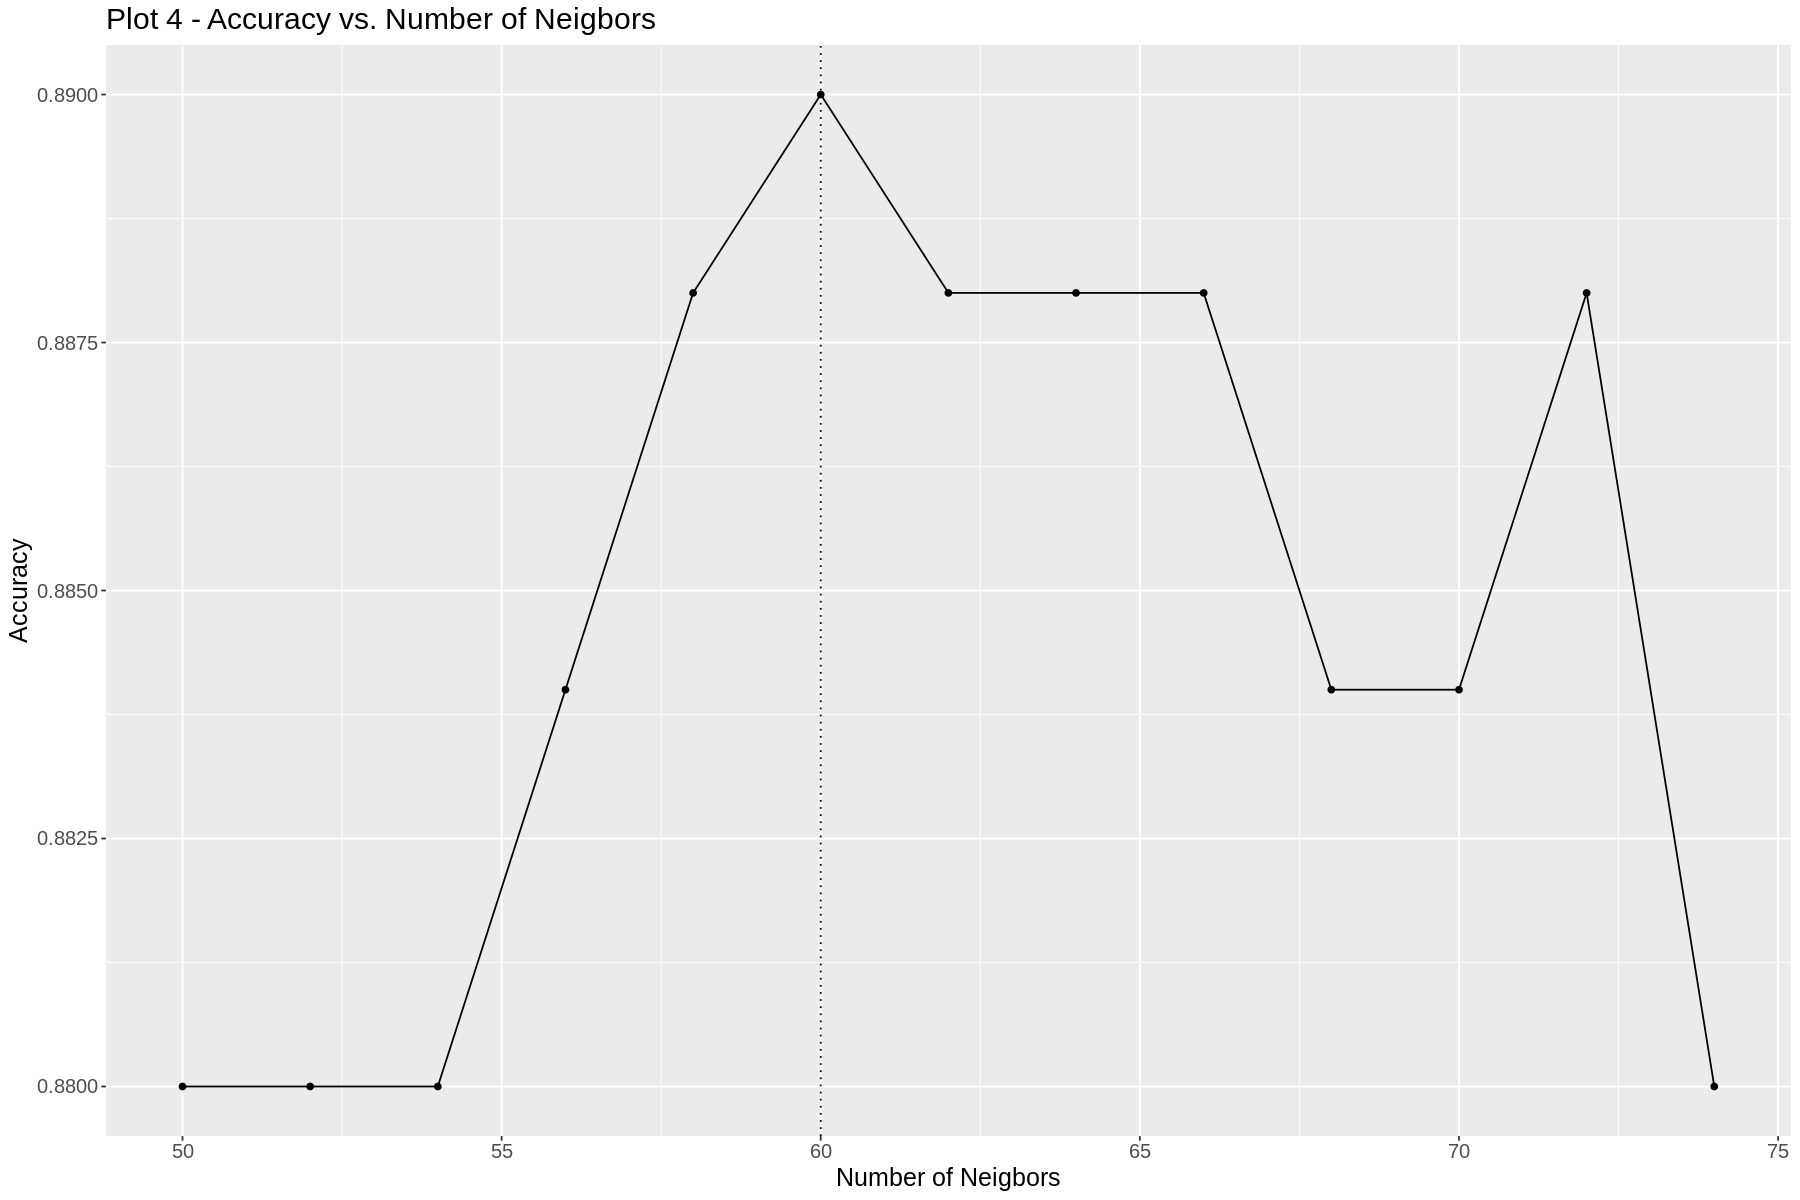

In [34]:
options(repr.plot.width = 15, repr.plot.height = 10)
number_of_neighbors_plot <- ggplot(number_of_neighbors_stats, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 60, linetype = "dotted") +
    labs(x = "Number of Neigbors", y = "Accuracy",
        title = "Plot 4 - Accuracy vs. Number of Neigbors") +
    theme(text = element_text(size = 15))

number_of_neighbors_plot

#### Training the Classifier & Accuracy Calculation

We then applied our K-NN model to the entire training data with the best K-value (60 neighbors) and calculated that our classifier performed with 92.0% accuracy on the training data. **uh i don't have any further comments to make about this accuracy value, but will use it to compare with the testing data accuracy for sure**

In [23]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) %>%
    set_engine('kknn') %>%
    set_mode('classification')

knn_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = weather_training)

weather_accuracy <- predict(knn_fit, weather_training) %>%
    bind_cols(weather_training) %>%
    metrics(truth = precipType, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
weather_accuracy

[1] 0.9199634

#### Applying Our Classifier to Testing Data

In [24]:
weather_predictions <- predict(knn_fit, weather_testing) %>%
                bind_cols(weather_testing) %>%
                glimpse()

Rows: 1,873
Columns: 7
$ .pred_class       <fct> rain, rain, rain, rain, rain, snow, rain, rain, rai…
$ Country           <chr> "US", "US", "US", "US", "US", "US", "US", "US", "US…
$ precipProbability <dbl> 0.03, 0.07, 0.48, 0.81, 0.14, 0.04, 0.98, 0.48, 0.5…
$ temperatureHigh   <dbl> 63.61, 68.21, 72.76, 69.94, 70.16, 45.51, 50.58, 58…
$ temperatureLow    <dbl> 34.41, 58.47, 63.81, 49.48, 51.39, 23.68, 47.70, 33…
$ dewPoint          <dbl> 29.19, 38.20, 63.26, 53.98, 28.14, 16.65, 37.77, 45…
$ precipType        <fct> rain, rain, rain, rain, rain, snow, rain, rain, rai…


`Table 10: ` Testing Dataset

### Results

Our classifier obtained an accuracy of about 91.3%, which (as expected) is slightly lower than the accuracy obtained after running our classifier on the training data. We then obtained a confusion matrix of our data and summarized the results in a table (`weather_conf_stats`).


In [25]:
weather_predictions_accuracy <- weather_predictions %>%
                metrics(truth = precipType, estimate = .pred_class) %>%
                filter(.metric == "accuracy") %>%
                select(.estimate) %>%
                pull()
weather_predictions_accuracy

[1] 0.9129738

In [26]:
weather_confusion_matrix <- weather_predictions %>%
                conf_mat(truth = precipType, estimate = .pred_class) 
weather_confusion_matrix

          Truth
Prediction rain snow
      rain 1233   93
      snow   70  477

`Table 11: ` Confusion Matrix Showing the Number of Correctly and Incorrectly Predicted precipType labels

In [27]:
# Values obtained from confusion matrix...
true_rain <- 1233 # Number of data points correctly classified as "rain"
true_snow <- 477 # Number of data points correctly classified as "snow"
false_rain <- 93 # Number of data points incorrectly classified as "rain"
false_snow <- 70 # Number of data points incorrectly classified as "snow"

weather_conf_stats <- weather_predictions %>%
                select(precipType) %>%
                count(precipType) %>%
                mutate(correct = c(true_rain, true_snow),
                       incorrect = c(false_rain, false_snow),
                       prop_correct = correct/n,
                       prop_incorrect = incorrect/n,
                       overall_accuracy = weather_predictions_accuracy) %>%
                rename("number_of_observations" = n)
weather_conf_stats

precipType,number_of_observations,correct,incorrect,prop_correct,prop_incorrect,overall_accuracy
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rain,1303,1233,93,0.9462778,0.07137375,0.9129738
snow,570,477,70,0.8368421,0.12280702,0.9129738


`Table 12 :` Summary Table Showing the Total Number of Observations, Correct & Incorrect Predictions, Proportion of Correct & Incorrect Predictions, and the Accuracy of the Classification Model for Each precipType Lable in the Testing Dataset 

#### Visualization of Results

placeholder Dealing with in a sec

Rows: 1,873
Columns: 3
$ .pred_class <fct> rain, rain, rain, rain, rain, snow, rain, rain, rain, rai…
$ precipType  <fct> rain, rain, rain, rain, rain, snow, rain, rain, rain, rai…
$ answer      <chr> "correct", "correct", "correct", "correct", "correct", "c…


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

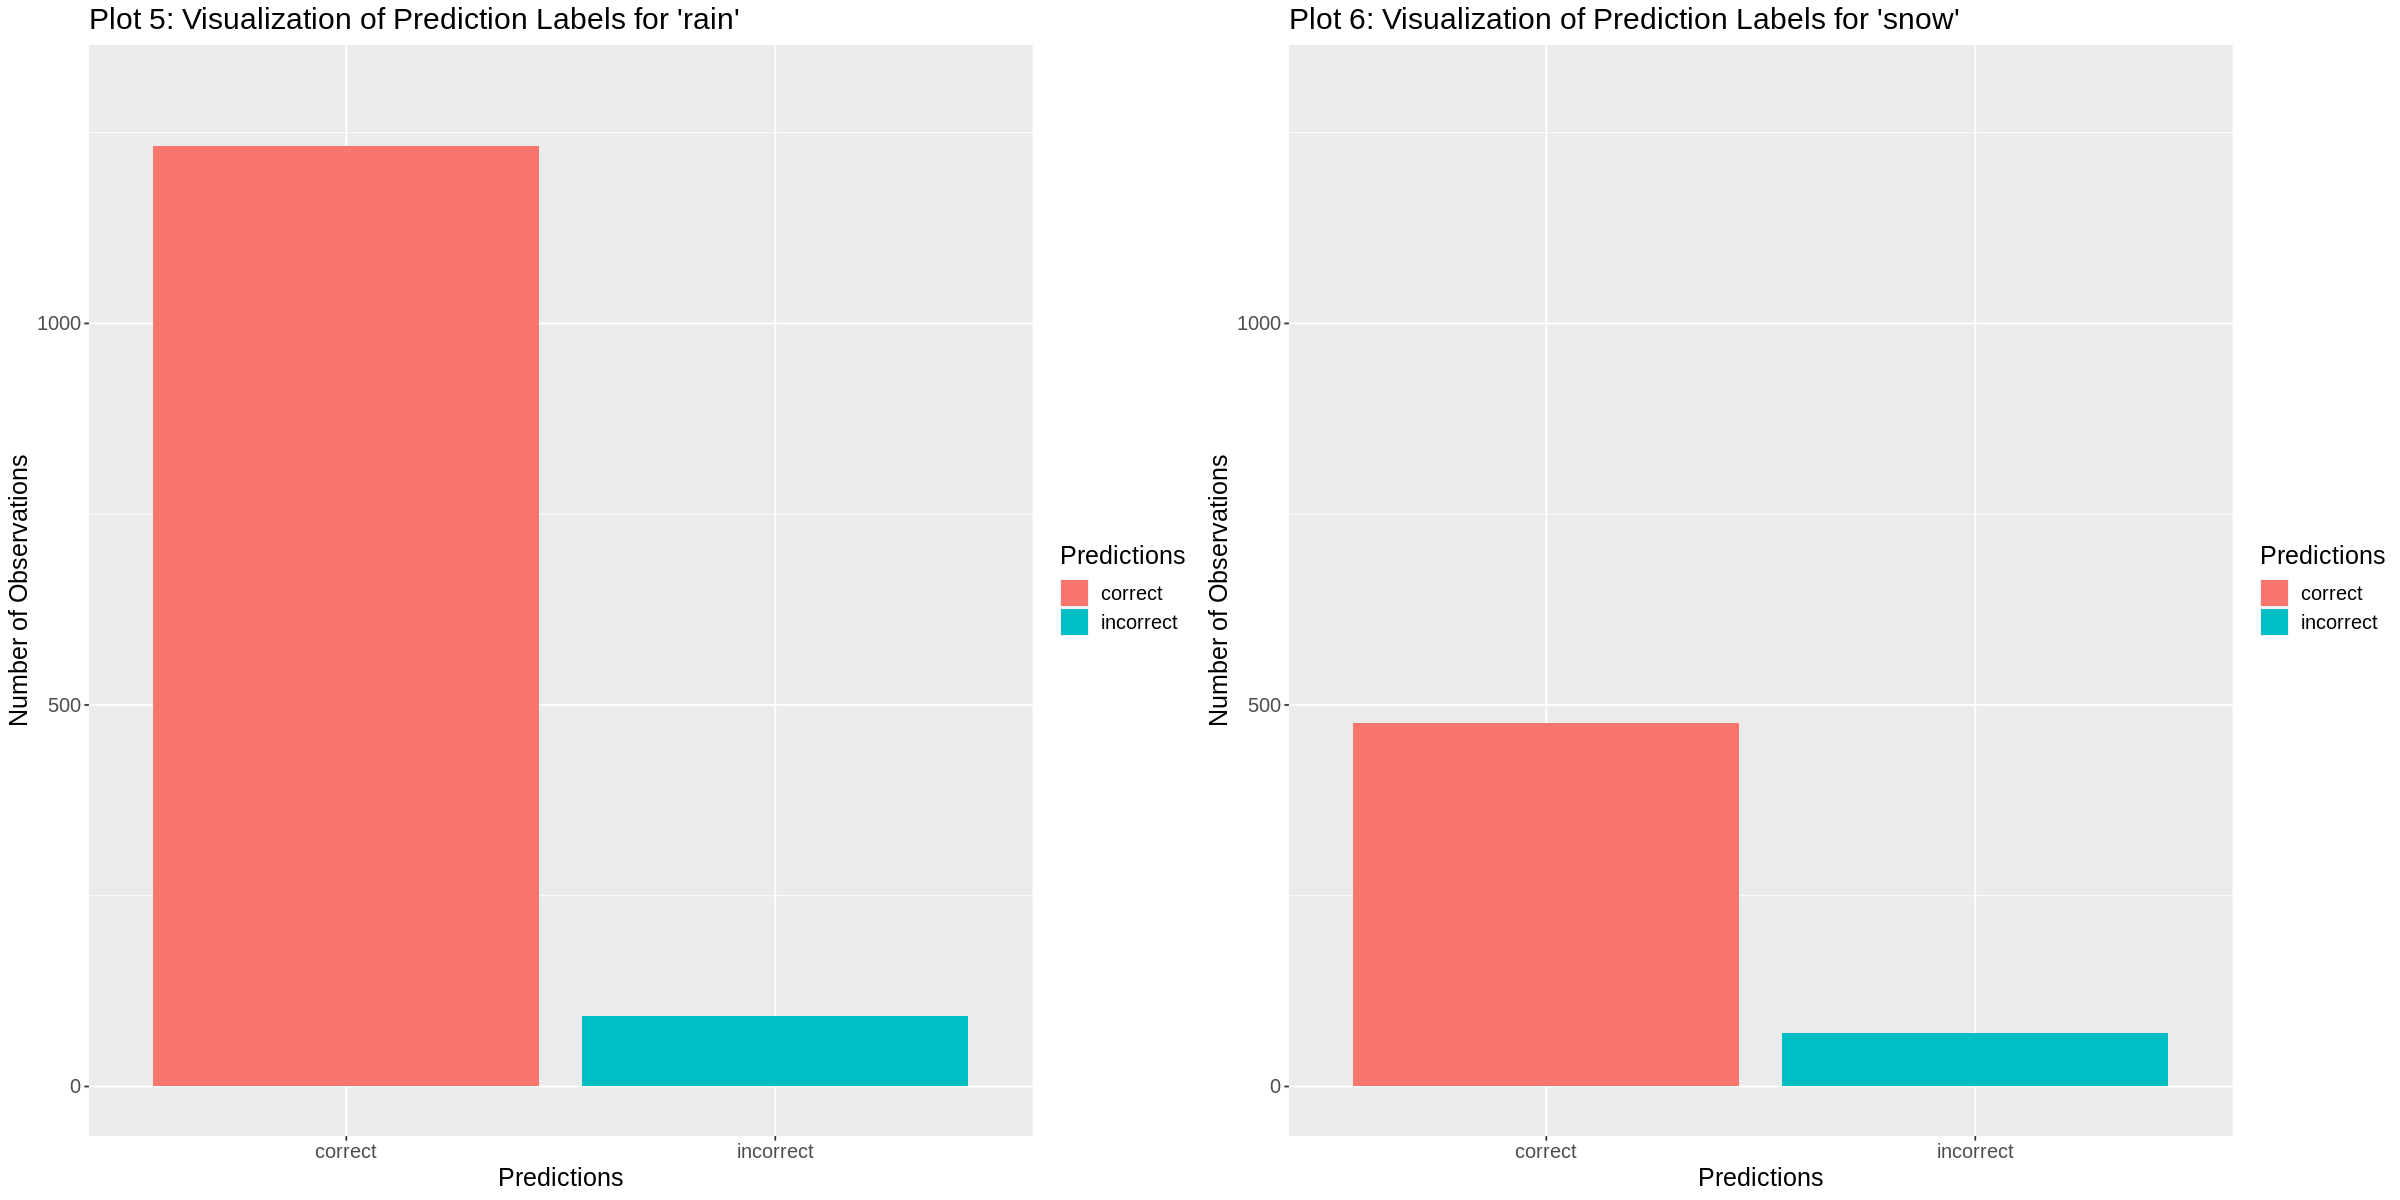

In [36]:
correct_predictions <- weather_predictions %>%
            select(.pred_class, precipType) %>%
            filter(.pred_class == precipType) %>%
            mutate(answer = "correct")
# correct_predictions

incorrect_predictions <- weather_predictions %>%
            select(.pred_class, precipType) %>%
            filter(.pred_class != precipType) %>%
            mutate(answer = "incorrect")
# incorrect_predictions

both_predictions <- rbind(correct_predictions, incorrect_predictions) %>%
            glimpse()

options(repr.plot.width = 20, repr.plot.height = 10)

rain_visualization <- both_predictions %>%
                    filter(.pred_class == "rain") %>%
                    ggplot(aes(x = answer, fill = answer)) +
                    geom_histogram(stat = "count") +
                    theme(text = element_text(size = 15)) +
                    ylim(0, 1300) +
                    labs(y = "Number of Observations", x = "Predictions", fill = "Predictions") +
                    ggtitle("Plot 5: Visualization of Prediction Labels for 'rain'")

snow_visualization <- both_predictions %>%
                    filter(.pred_class == "snow") %>%
                    ggplot(aes(x = answer, fill = answer)) +
                    geom_histogram(stat = "count") +
                    ylim(0, 1300) +
                    theme(text = element_text(size = 15)) +
                    labs(y = "Number of Observations", x = "Predictions", fill = "Predictions") +
                    ggtitle("Plot 6: Visualization of Prediction Labels for 'snow'")

visualization_together <- grid.arrange(rain_visualization, snow_visualization, ncol = 2)
visualization_together

### Discussion of Results:

   It is expected to find that when the temperature is low, that the precipitation phase is low. Both the `temperatureHigh` and `temperatureLow` visualization outcomes are expected; when the temperature is below approximately 30 °F for `temperatureLow` and below 50 °F for `temperatureHigh`, it is most likely to snow. Similarly, for dew point, which is the temperature at which water droplets begin to condense, the visualization shows that rain switches to precipitation phase when the dew point is approximately 25 °F. The results align with common weather knowledge, that snow forms at approximately 30 °F. Though, the classifier did have more trouble predicting snow, and it’s accuracy was less than that for predicting snow. This could also be because of global warming, as “the relationship between air temperature and precipitation phase is based on the idea that climate and conditions during storms are stable and predictable over time, such that an empirical approach is satisfactory. As we suspect that this is no longer the case, it is important that we use methods that are more physically related to precipitation phase” (https://www.sciencedirect.com/science/article/pii/S0309170812002941). 

   The goal of predicting the type of precipitation is to provide information that people and organizations can use to reduce weather-related losses and enhance societal benefits. This includes protecting life and property, public health and safety, and support of economic prosperity and quality of life, as well as alerting businesses that rely on the weather (like farming or fishing), warning drivers to be cautious on the roads with certain weather conditions, to notify people how they should dress to stay safe and warm. If “air temperature [and] dew point are below 0 °C it should be snowing, and if above 0 °C it should be raining”(https://www.sciencedirect.com/science/article/pii/S0309170812002941), but because of global warming, forecasting the precipitation phase based on this factor/knowledge alone, can be unpredictable. Using a classifier and data analysis can give a more precise estimate, and therefore less damage. 
   
   The data used in this classifier, is for the United States in total, it’s not specific to regions within the US. Climates can vary across the country, so this classifier could be made to be even more precise. We could ask what taking into account areas of the United States that have a closer climate or are more susceptible to snow, as opposed to the warmer climates, would do to change the classifier? How would tailoring our model to specific climates within the United States affect the accuracy of our classifier? We also just use rain and snow as our precipitation phases, but how would our classifier be impacted if frozen rain and sleet were taken into consideration and visualized? Predicting the weather is already a very fickle and difficult task, but with the current situation of global warming, forecasting weather has become even more challenging. Making a classifier using only three predictors is also very limiting, and there are dozens of other variables to be taken into account when predicting weather, which are all specific to past patterns in specific regions. This can also lead to the following question: how would including other variables and several regions improve the classifier? What we explore in this particular analysis is just scratching the surface of precipitation prediction and weather prediction. Yet due to the current day circumstances with climate change, predicting weather based on past knowledge is insufficient, and data analysis is necessary for accurate weather forecasting in present and future. 